In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Search for all DTL.log files
datalogs = {}

# Define the column names
column_names = [
    "model", "mode", "epoch",  "travel_time", "loss", "reward", "queue", "delay", "throughput"
]

all_log_paths = list(Path("experiment").rglob("*DTL.log"))
model_folders = {p.parent for p in all_log_paths}

for model_folder in model_folders:
    world = model_folder.parent.name
    model  = model_folder.name
    
    datalogs.setdefault(world, {})[model] = []
    
    for log_path in model_folder.glob("*DTL.log"):
        df = pd.read_csv(log_path, sep="\t", names=column_names)
        print(f"world: {world}, model: {model}, log_path: {log_path}")
        datalogs[world][model].append(df)


world: sumo, model: colight, log_path: experiment/sumo/colight/2025_07_25-05_47_52_DTL.log
world: sumo, model: colight, log_path: experiment/sumo/colight/2025_07_25-13_09_38_DTL.log
world: sumo, model: maxpressure, log_path: experiment/sumo/maxpressure/2025_07_26-00_24_29_DTL.log
world: sumo, model: maxpressure, log_path: experiment/sumo/maxpressure/2025_07_25-10_11_23_DTL.log
world: sumo, model: presslight, log_path: experiment/sumo/presslight/2025_07_25-04_20_37_DTL.log
world: sumo, model: presslight, log_path: experiment/sumo/presslight/2025_07_25-11_41_20_DTL.log
world: sumo, model: dqn, log_path: experiment/sumo/dqn/2025_07_25-10_11_53_DTL.log
world: sumo, model: dqn, log_path: experiment/sumo/dqn/2025_07_25-02_52_22_DTL.log


In [3]:
def plot_with_confidence(dfs, label=None, color=None):
    # Drop the last row from each DataFrame
    trimmed = [df.iloc[:-1] for df in dfs]

    # Align on epoch
    merged = pd.concat([df[['epoch', 'travel_time']].set_index('epoch') for df in trimmed], axis=1)
    merged.columns = [f'run_{i}' for i in range(len(trimmed))]

    # Compute mean and std
    mean = merged.mean(axis=1)
    std  = merged.std(axis=1)

    # Plot with confidence band
    plt.plot(mean.index, mean, label=label, color=color)
    plt.fill_between(mean.index, mean - std, mean + std, color=color, alpha=0.3)


In [4]:
def plot_with_confidence_notrain(dfs, episodes = 100, label=None, color=None):    
    # Align on epoch
    merged = pd.concat([df[['epoch', 'travel_time']].set_index('epoch') for df in dfs], axis=1)
    merged.columns = [f'run_{i}' for i in range(len(dfs))]

    print(merged)
    # Compute mean and std
    mean = merged.mean(axis=1)
    std  = merged.std(axis=1)

    # Plot with confidence band
    plt.hlines(mean, 0, episodes, label=label, color=color, linestyles='dashed')
    # plt.fill_between(mean.index, mean - std, mean + std, color=color, alpha=0.3)
    plt.fill_between(
        x=[0, episodes],
        y1=mean - std,
        y2=mean + std,
        color=color,
        alpha=0.3
    )

       run_0  run_1
epoch              
0       59.5   59.5


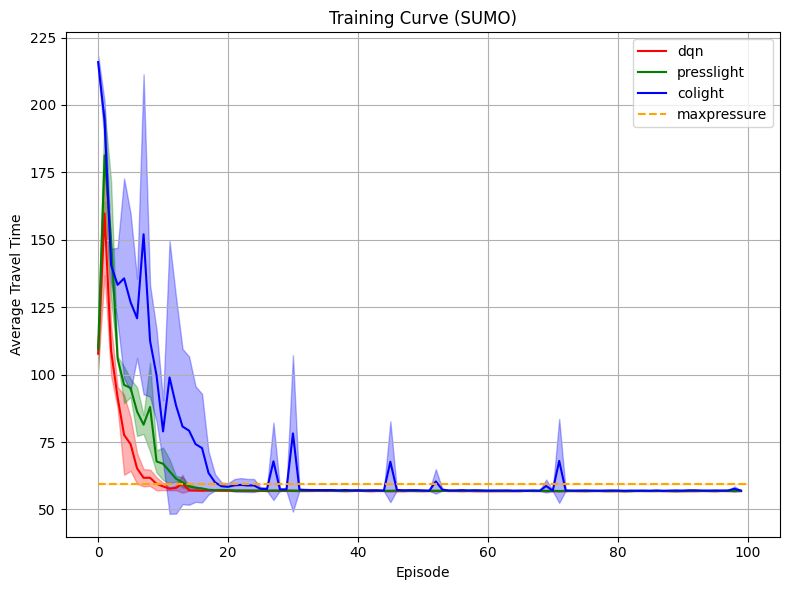

In [5]:
# plot training curve

plt.figure(figsize=(8, 6))
plot_with_confidence(datalogs["sumo"]["dqn"], label="dqn", color="red")
plot_with_confidence(datalogs["sumo"]["presslight"], label="presslight", color="green")
plot_with_confidence(datalogs["sumo"]["colight"], label="colight", color="blue")
plot_with_confidence_notrain(datalogs["sumo"]["maxpressure"], label="maxpressure", color="orange")
plt.xlabel("Episode")
plt.ylabel("Average Travel Time")
plt.title("Training Curve (SUMO)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
mean_rows = []
std_rows = []
model_names = []

for model, model_dfs in datalogs['sumo'].items():
    final_tests = [df.iloc[-1].drop(['model','mode', 'epoch']) for df in model_dfs]
    merged = pd.concat(final_tests, axis=1)
    
    mean_row = merged.mean(axis=1)
    mean_rows.append(mean_row)
    
    std_row = merged.std(axis=1)
    std_rows.append(std_row)
    
    model_names.append(model)
    

mean_df = pd.concat(mean_rows, axis=1)
mean_df.columns = model_names
# mean_df = mean_df.T

std_df = pd.concat(std_rows, axis=1)
std_df.columns = model_names
# std_df = std_df.T
    

In [7]:
mean_df.T


,travel_time,loss,reward,queue,delay,throughput
colight,56.9,100.0,-14.05,1.745,0.12,55595.0
maxpressure,59.5,100.0,-93.59,2.58,2.4,55578.0
presslight,56.85,100.0,-44.05,1.69,0.115,55594.0
dqn,56.75,100.0,-12.91,1.67,0.11,55583.0


In [8]:
std_df.T

,travel_time,loss,reward,queue,delay,throughput
colight,0.0,0.0,0.0,0.007071,0.0,9.899495
maxpressure,0.0,0.0,0.0,0.0,0.0,0.0
presslight,0.070711,0.0,0.084853,0.014142,0.007071,5.656854
dqn,0.070711,0.0,0.084853,0.014142,0.0,29.698485
